In [1]:
from pathlib import Path
parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [2]:
from utils import *
from ergm import ERGM
from metrics import *

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# Replicating the `Sampson` example from R's ERGM
The original R ERGM paper (Hunter et al. 2008) begins with a basic example of modeling Sampson's Monestary data, which consists of a directed network with $n=18$ nodes. This network models social interactions among a group of monks (See Sampson 1969 for more details). 

In the paper, An ERGM model is fit based on the Sampson network, using `num_of_edges` as its sole feature. The R fit yields a coefficient of `-0.9071582`, which is our aim.

In [3]:
# Matrix copied manually, TODO - Create a `data` dir in our project and save as a pickle or something.
sampson_matrix = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 
    [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], 
    [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)


optimization started
Step 0 - true_grad: 0, grad: [0.], window_grad: 116.27 lr: 0.0010000000, thetas: [0.68328371], time from start: 0.06, n_networks_for_grad_estimation: 500, sliding_grad_window_k: 20


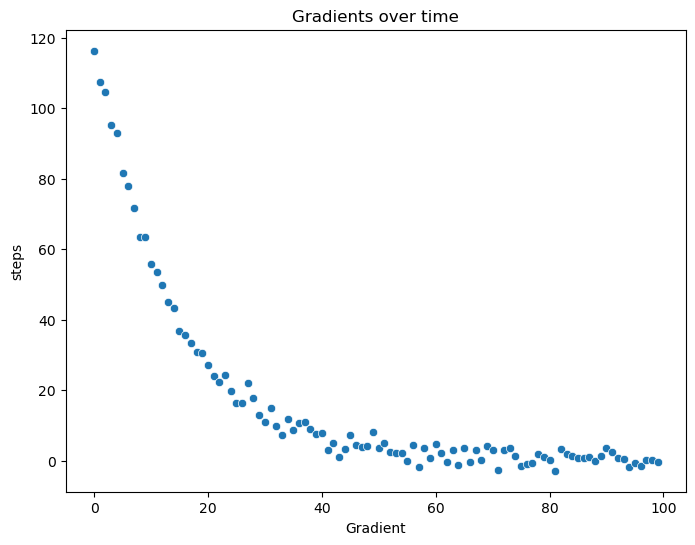

Fitted theta: [-0.90155555]


In [5]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()
fitted_model = ERGM(n, [number_of_edges_metric], is_directed=is_directed, n_networks_for_grad_estimation=500, n_mcmc_steps=50)

grads, _ = fitted_model.fit(sampson_matrix, lr=0.001, opt_steps=100, sliding_grad_window_k=20, sample_pct_growth=0.05)

grads = [x[0] for x in grads]


fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

As we can see, our model reaches a theta that is extremely close to the actual R result.

## Now test a model with TotalReciprocity + NumberOfEdges

0.2875816993464052

optimization started
Step 0 - true_grad: 0, grad: [0. 0.], window_grad: 80.17 lr: 0.0100000000, thetas: [-0.82738843  0.29967108], time from start: 0.37, n_networks_for_grad_estimation: 500, sliding_grad_window_k: 20
Step 100 - true_grad: 0, grad: [4.98145859 1.73053152], window_grad: -0.17 lr: 0.0034867844, thetas: [-1.74441727  2.30015245], time from start: 45.00, n_networks_for_grad_estimation: 809, sliding_grad_window_k: 39
Reached threshold of 0.001 after 145 steps. DONE!


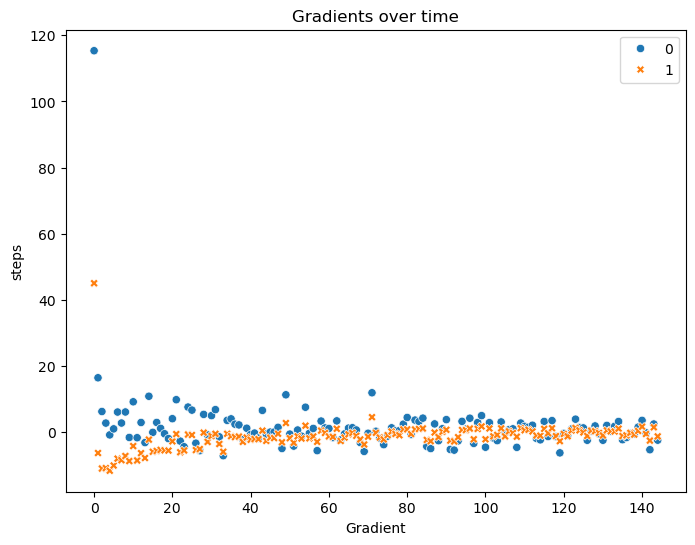

Fitted theta: [-1.75923194  2.32294555]


In [14]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()

estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

fitted_model = ERGM(n, [number_of_edges_metric, TotalReciprocity()], is_directed=is_directed, n_networks_for_grad_estimation=500, n_mcmc_steps=100, seed_MCMC_proba=estimated_p_seed)
grads, _ = fitted_model.fit(sampson_matrix, lr=0.01, opt_steps=400, sliding_grad_window_k=20, sample_pct_growth=0.05, lr_decay_pct=0.1, steps_for_decay=10)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='Gradient', ylabel='steps')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

#### Took a while (~1 minute), but results are pretty close!
True results in R -
* $\theta_1 = -1.7625$
* $\theta_2 = 2.3132$

## And finally we test the full $p_1$ model

optimization started
Step 0 - true_grad: 0, grad: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], window_grad: 15.16 lr: 0.0010000000, thetas: [ 0.51866264 -0.2977325   0.78156513  0.60496574 -0.57916339  0.48282363
  0.02108701  0.96057289 -0.34830811 -0.37438033  0.446358   -0.595762
 -0.35338944  0.52769287 -0.33086043  0.66858695 -0.18332256  0.58278428
 -0.1260201  -0.94285381  0.31121622  0.05167307  0.64315027  0.89102747
  0.2450292  -0.13266298  0.56844032  0.1140374  -0.03016221 -0.18646357
  0.33930104  0.12463567 -0.25158466  0.81008681  0.54862664  0.92019793], time from start: 0.09, n_networks_for_grad_estimation: 500, sliding_grad_window_k: 30
Step 100 - true_grad: 0, grad: [ 4.94373866 -1.43194192  1.07985481  2.22504537 -1.31215971  1.73684211
  0.26315789  2.66606171  0.22686025 -1.59891107  0.60798548 -0.58439201
  0.60435572  1.58257713 -2.38838475  0.84392015  0.07803993  0.73321234
 -4.73865699 -0.039

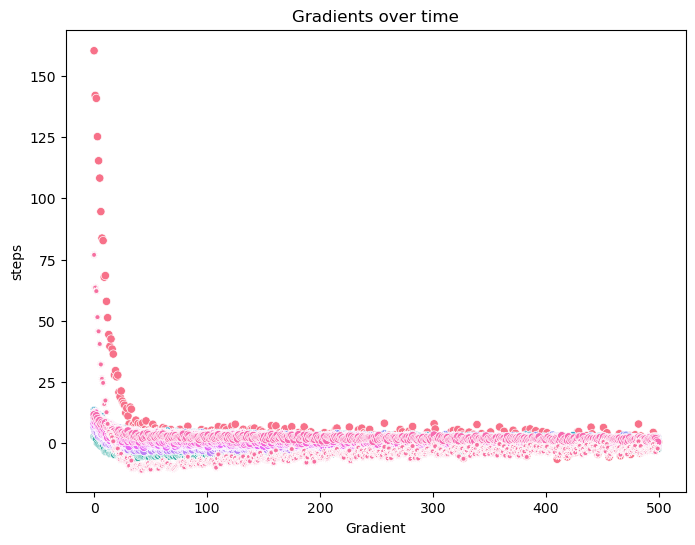

Fitted theta: [-1.62327673 -0.24694624  0.38633896 -0.03439592 -0.31169364 -0.03041313
 -0.110058    0.47559908 -0.32278448  0.08447014  0.18131239 -0.50931782
 -0.57457164  0.1158591   0.1041444   0.29239847 -0.2902932   0.39710714
  0.96594057 -0.91731095  0.08164964  0.66018428 -0.40894595  0.48917141
 -0.04009661 -0.21695522 -0.41758062 -0.42786775  0.46057437 -0.00575148
  0.26239346 -0.3843398  -0.58917848 -0.28589488 -0.29670042  2.11254403]


In [15]:
n = sampson_matrix.shape[0]
is_directed = True



estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, n_networks_for_grad_estimation=500, n_mcmc_steps=100, seed_MCMC_proba=estimated_p_seed)
grads, _ = fitted_model.fit(sampson_matrix, lr=0.001, opt_steps=500, sliding_grad_window_k=30, sample_pct_growth=0.05, lr_decay_pct=0.1, steps_for_decay=50)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='Gradient', ylabel='steps')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

In [7]:
fitted_model._network_statistics.metric_names

('num_edges_directed', 'total_reciprocity', 'indegree', 'outdegree')

In [21]:
grads[100, :]

array([ 0.35027223, -0.28856624,  1.44827586,  1.73684211, -1.57350272,
        1.40471869,  0.53357532,  2.14519056, -1.62250454, -1.44827586,
        0.09255898, -1.31215971,  0.20689655,  0.38656987, -1.78947368,
        0.95462795, -0.70598911,  1.43194192, -2.83666062, -0.38838475,
       -0.11252269, -2.59709619,  2.68239564,  0.78402904,  1.75680581,
       -1.16515426,  3.52631579,  0.95644283, -2.38656987, -1.54264973,
       -0.74228675,  1.3938294 ,  1.6061706 ,  2.8892922 ,  2.45190563,
       -6.86025408])

In [18]:
grads[-1, :]

array([ 0.79851669,  0.72435105,  0.90358467,  0.6526576 , -0.27564895,
        0.94437577, -0.29419036,  1.95302843, -0.47836836, -2.08899876,
        0.6934487 ,  0.        ,  0.14956737,  0.63658838, -0.9592089 ,
       -0.27935723,  0.41409147, -0.80098888, -2.41161928,  0.43634116,
        0.1421508 , -0.79851669,  2.23733004,  0.70210136,  1.31273177,
       -0.38071693,  1.55871446,  1.08899876, -1.14709518, -0.90976514,
        0.34239802,  1.22744129,  0.50803461,  2.6736712 ,  0.48207664,
       -2.18170581])